## Install Package yang diperlukan

In [1]:
!pip install jcopdl
!pip install tqdm

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=0a5649587e59187d6ace7b9a739068b2e3e44e91cb3fc3fffd330bc4d547382d
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


## Import Pakcage yang diperlukan

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block
from jcopdl.layers import linear_block, conv_block

from google.colab import files
import zipfile,os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Ekstraksi File Datasets

In [3]:
local_zip = '/content/CIFAR10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

base_dir = ('/content/cifar10/cifar10')
os.listdir(base_dir)

['train', 'test']

## Datasets dan Dataloader

In [4]:
bs = 128
crop_size = 32

transform_train = transforms.Compose([
    transforms.CenterCrop(crop_size),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("/content/cifar10/cifar10/train", transform=transform_train)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/cifar10/cifar10/test", transform=transform_test)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [5]:
# Cek Data
images, label = next(iter(trainloader))
images.shape

torch.Size([128, 3, 32, 32])

In [6]:
# label
label2cat = train_set.classes
label2cat

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
len(label2cat)

10

## Buat Arsitektur NN

In [10]:
class CifarCNN(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size, drout):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 16), # 3x32x32 -> 16x16x16
            conv_block(16, 32), # 16x16x16 -> 32x8x8 
            conv_block(32, 64), #32x8x8 -> 64x4x4
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(input_size, hidden1, dropout=0.1),
            linear_block(hidden1, hidden2, dropout=0.1),
            linear_block(hidden2, output_size, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(self.conv(x))

In [11]:
config = set_config({
    "bs" : 123,
    "crop_size" : 32,
    "input_layer" : 1024,
    "hidden1" : 512,
    "hidden2" : 64,
    "output_size" : len(label2cat),
    "drout" : 0.1
})

## Training Preparation

In [13]:
model = CifarCNN(config.input_layer, config.hidden1, config.hidden2, config.output_size, config.drout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model_weight", early_stop_patience=10, plot_every=50)

## Proses Training

In [14]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 1.7791 | Test_cost  = 1.4901 | Train_score = 0.3395 | Test_score = 0.4545 |




Epoch     2
Train_cost  = 1.4382 | Test_cost  = 1.3149 | Train_score = 0.4780 | Test_score = 0.5220 |




Epoch     3
Train_cost  = 1.2875 | Test_cost  = 1.1751 | Train_score = 0.5372 | Test_score = 0.5747 |




Epoch     4
Train_cost  = 1.1803 | Test_cost  = 1.1358 | Train_score = 0.5799 | Test_score = 0.6022 |




Epoch     5
Train_cost  = 1.0925 | Test_cost  = 1.0494 | Train_score = 0.6128 | Test_score = 0.6296 |




Epoch     6
Train_cost  = 1.0298 | Test_cost  = 0.9649 | Train_score = 0.6381 | Test_score = 0.6623 |




Epoch     7
Train_cost  = 0.9690 | Test_cost  = 0.9663 | Train_score = 0.6595 | Test_score = 0.6590 |
==> EarlyStop patience =  1 | Best test_score: 0.6623




Epoch     8
Train_cost  = 0.9290 | Test_cost  = 0.9004 | Train_score = 0.6754 | Test_score = 0.6886 |




Epoch     9
Train_cost  = 0.8793 | Test_cost  = 0.8715 | Train_score = 0.6922 | Test_score = 0.6984 |




Epoch    10
Train_cost  = 0.8444 | Test_cost  = 0.8172 | Train_score = 0.7055 | Test_score = 0.7159 |




Epoch    11
Train_cost  = 0.8072 | Test_cost  = 0.8048 | Train_score = 0.7179 | Test_score = 0.7200 |




Epoch    12
Train_cost  = 0.7805 | Test_cost  = 0.8137 | Train_score = 0.7281 | Test_score = 0.7196 |
==> EarlyStop patience =  1 | Best test_score: 0.7200




Epoch    13
Train_cost  = 0.7576 | Test_cost  = 0.7951 | Train_score = 0.7353 | Test_score = 0.7270 |




Epoch    14
Train_cost  = 0.7353 | Test_cost  = 0.7770 | Train_score = 0.7438 | Test_score = 0.7337 |




Epoch    15
Train_cost  = 0.7126 | Test_cost  = 0.7553 | Train_score = 0.7532 | Test_score = 0.7410 |




Epoch    16
Train_cost  = 0.6946 | Test_cost  = 0.7258 | Train_score = 0.7556 | Test_score = 0.7525 |




Epoch    17
Train_cost  = 0.6778 | Test_cost  = 0.7234 | Train_score = 0.7633 | Test_score = 0.7510 |
==> EarlyStop patience =  1 | Best test_score: 0.7525




Epoch    18
Train_cost  = 0.6632 | Test_cost  = 0.7145 | Train_score = 0.7678 | Test_score = 0.7546 |




Epoch    19
Train_cost  = 0.6458 | Test_cost  = 0.7137 | Train_score = 0.7756 | Test_score = 0.7573 |




Epoch    20
Train_cost  = 0.6195 | Test_cost  = 0.7070 | Train_score = 0.7831 | Test_score = 0.7592 |




Epoch    21
Train_cost  = 0.6108 | Test_cost  = 0.6924 | Train_score = 0.7865 | Test_score = 0.7650 |




Epoch    22
Train_cost  = 0.5953 | Test_cost  = 0.7160 | Train_score = 0.7925 | Test_score = 0.7560 |
==> EarlyStop patience =  1 | Best test_score: 0.7650




Epoch    23
Train_cost  = 0.5900 | Test_cost  = 0.7106 | Train_score = 0.7928 | Test_score = 0.7594 |
==> EarlyStop patience =  2 | Best test_score: 0.7650




Epoch    24
Train_cost  = 0.5713 | Test_cost  = 0.7092 | Train_score = 0.8001 | Test_score = 0.7614 |
==> EarlyStop patience =  3 | Best test_score: 0.7650




Epoch    25
Train_cost  = 0.5613 | Test_cost  = 0.7034 | Train_score = 0.8036 | Test_score = 0.7666 |




Epoch    26
Train_cost  = 0.5473 | Test_cost  = 0.7134 | Train_score = 0.8064 | Test_score = 0.7588 |
==> EarlyStop patience =  1 | Best test_score: 0.7666




Epoch    27
Train_cost  = 0.5366 | Test_cost  = 0.6825 | Train_score = 0.8100 | Test_score = 0.7740 |




Epoch    28
Train_cost  = 0.5246 | Test_cost  = 0.6955 | Train_score = 0.8151 | Test_score = 0.7687 |
==> EarlyStop patience =  1 | Best test_score: 0.7740




Epoch    29
Train_cost  = 0.5234 | Test_cost  = 0.7263 | Train_score = 0.8166 | Test_score = 0.7600 |
==> EarlyStop patience =  2 | Best test_score: 0.7740




Epoch    30
Train_cost  = 0.5112 | Test_cost  = 0.7000 | Train_score = 0.8196 | Test_score = 0.7661 |
==> EarlyStop patience =  3 | Best test_score: 0.7740




Epoch    31
Train_cost  = 0.4956 | Test_cost  = 0.7052 | Train_score = 0.8265 | Test_score = 0.7662 |
==> EarlyStop patience =  4 | Best test_score: 0.7740




Epoch    32
Train_cost  = 0.4947 | Test_cost  = 0.7157 | Train_score = 0.8254 | Test_score = 0.7673 |
==> EarlyStop patience =  5 | Best test_score: 0.7740




Epoch    33
Train_cost  = 0.4856 | Test_cost  = 0.7114 | Train_score = 0.8295 | Test_score = 0.7660 |
==> EarlyStop patience =  6 | Best test_score: 0.7740




Epoch    34
Train_cost  = 0.4790 | Test_cost  = 0.7057 | Train_score = 0.8308 | Test_score = 0.7737 |
==> EarlyStop patience =  7 | Best test_score: 0.7740




Epoch    35
Train_cost  = 0.4681 | Test_cost  = 0.7141 | Train_score = 0.8358 | Test_score = 0.7703 |
==> EarlyStop patience =  8 | Best test_score: 0.7740




Epoch    36
Train_cost  = 0.4698 | Test_cost  = 0.7153 | Train_score = 0.8346 | Test_score = 0.7699 |
==> EarlyStop patience =  9 | Best test_score: 0.7740




Epoch    37
Train_cost  = 0.4618 | Test_cost  = 0.7072 | Train_score = 0.8358 | Test_score = 0.7695 |
==> EarlyStop patience = 10 | Best test_score: 0.7740
==> Execute Early Stopping at epoch: 37 | Best test_score: 0.7740
==> Best model is saved at model_weight


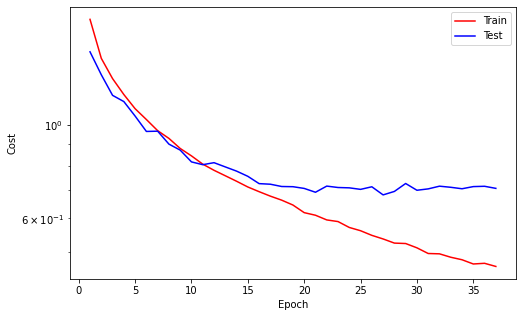

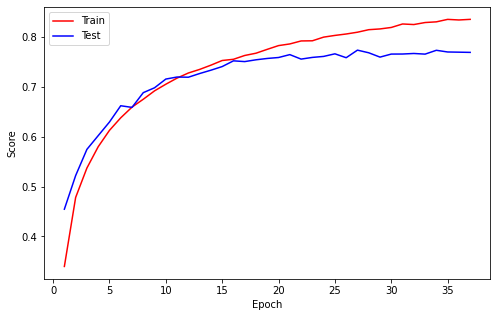

In [15]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Prediksi

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [18]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

preds

tensor([5, 9, 6, 7, 6, 6, 8, 0, 4, 3, 9, 2, 3, 1, 2, 1, 2, 2, 7, 5, 0, 1, 9, 2,
        6, 3, 5, 1, 7, 9, 9, 6, 6, 8, 8, 5, 3, 4, 0, 5, 2, 0, 7, 1, 8, 3, 2, 4,
        7, 4, 3, 7, 5, 6, 9, 3, 5, 5, 9, 8, 2, 4, 8, 3, 3, 7, 7, 1, 7, 6, 9, 8,
        0, 9, 2, 7, 0, 2, 1, 8, 7, 2, 4, 5, 0, 2, 5, 5, 0, 0, 0, 4, 6, 1, 6, 7,
        8, 2, 5, 9, 2, 8, 1, 7, 6, 4, 9, 9, 8, 8, 1, 6, 7, 6, 1, 9, 6, 6, 1, 5,
        4, 4, 7, 8, 8, 0, 1, 7], device='cuda:0')

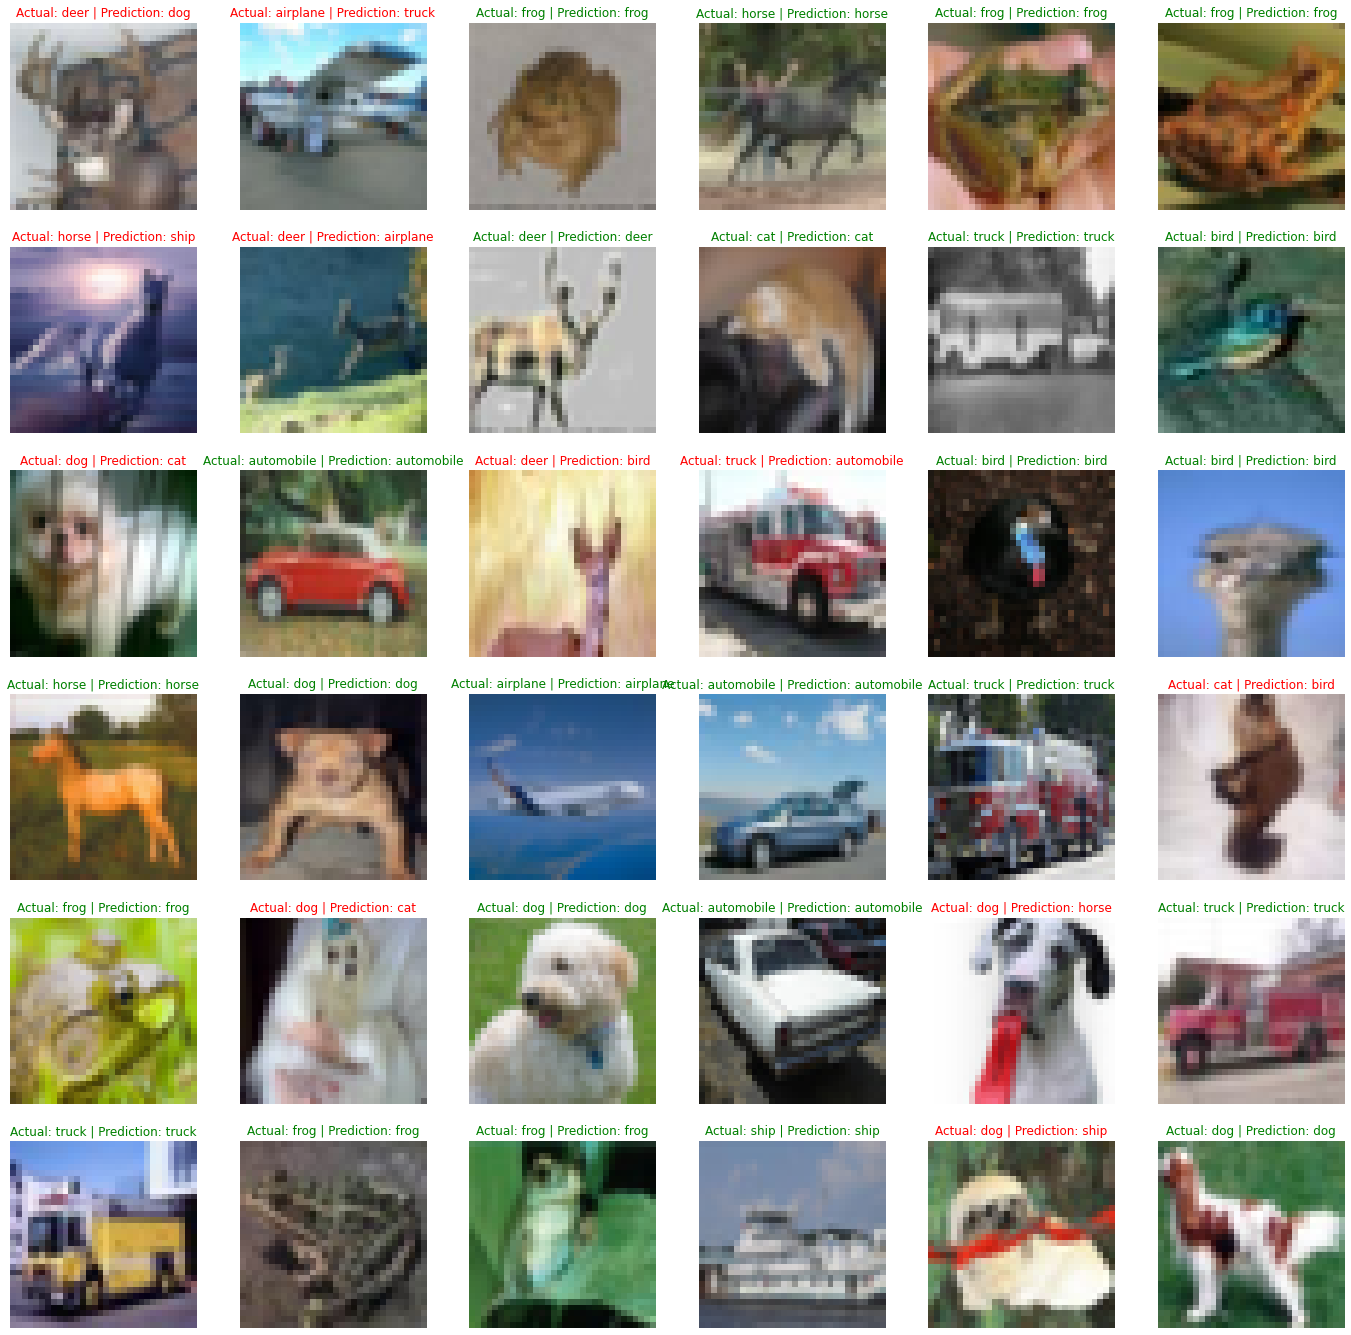

In [19]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color":"r"} if label != pred else {"color":"g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Actual: {label} | Prediction: {pred}", fontdict=font);
    ax.axis('off');